In [3094]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

## Creating delivary locations

In [3095]:
def create_delivary(x,y,n):
    x_range = [x[0], y[0]]
    y_range = [x[1], y[1]]
    loc = []

    for i in range(n):
        x_loc = random.uniform(x_range[0], x_range[1])
        y_loc = random.uniform(y_range[0], y_range[1])
        loc.append([x_loc, y_loc])

    return loc

## Visualizations

In [3096]:
def primary_plot(delivary_loc, obstacles):
    delivary_loc = np.array(delivary_loc)
    plt.scatter(delivary_loc[:,0], delivary_loc[:,1], label="Delivary loc")

    for obstacle_id, points in obstacles.items():
        start_x, start_y = points[0]
        end_x, end_y = points[1]
        plt.fill([start_x, end_x, end_x, start_x], [start_y, start_y, end_y, end_y],
                 label="Obstacle", alpha=0.7, color='red')
    # plt.legend()

In [3097]:
def plot_dp(dp, delivary_loc, obstacles):
    primary_plot(delivary_loc, obstacles)
    plt.scatter(dp[0], dp[1], marker='^', c="black", label = "DP")
    # plt.legend()
    # plt.show()

In [3098]:
def plot_initial_route(dp, delivary_loc, obstacles, route):
    plot_dp(dp, delivary_loc, obstacles)
    for i in range(len(route)-1):
        f_pt = np.array([route[i][0], route[i+1][0]])
        s_pt = np.array([route[i][1], route[i+1][1]])
        plt.plot(f_pt, s_pt, c="gray")

## Calculate DP

In [3099]:
def calculate_dp(delivary_loc):
    x = [i for i,j in delivary_loc]
    y = [j for i,j in delivary_loc]

    x_axis = np.mean(x)
    y_axis = np.mean(y)

    return [x_axis, y_axis]

## Create Route

In [3100]:
def create_route(pts, extra):
    idx = 0
    k = len(pts)
    for i in range(k):
        pts.insert(idx, extra)
        idx +=2

    pts.append(extra)
    return pts

## Distance Calculate

In [3101]:
def euc_distance(pt1, pt2):
    pt1 = np.array(pt1)
    pt2 = np.array(pt2)
    return np.sqrt(np.sum((pt2 - pt1)**2))

In [3102]:
def total_dist(pts):
    sum = 0
    for i in range(len(pts)-1):
        sum += euc_distance(pts[i], pts[i+1])

    return sum

## Check for obstacles

In [3103]:
from shapely.geometry import LineString, Polygon, Point

def check_obstacle_in_line(point_a, point_b, obstacles):
  line = LineString([point_a, point_b])

  for obstacle_id, points in obstacles.items():
    pt1 = points[0]
    pt2 = points[1]
    coord = [[pt1[0],pt1[1]], [pt2[0],pt1[1]], [pt2[0], pt2[1]], [pt1[0], pt2[1]], [pt1[0],pt1[1]]]
    obstacle = Polygon(coord)
    if line.intersects(obstacle):
      return True

  return False

In [3104]:
def detect_obstacle(route, obstacles):
    for i in range(0,len(route)-1,2):
        if check_obstacle_in_line(route[i],route[i+1], obstacles):
            return True
    return False

## Generate Intermediate Point

In [3105]:
import math

def find_inter_point(point_a, point_b, obstacles):
    route_line = LineString([point_a, point_b])

    # Find all intersections with obstacles (including edges)
    intersections = []
    for obstacle_id, points in obstacles.items():
        pt1 = points[0]
        pt2 = points[1]
        coord = [[pt1[0],pt1[1]], [pt2[0],pt1[1]], [pt2[0], pt2[1]], [pt1[0], pt2[1]], [pt1[0],pt1[1]]]
        obstacle = Polygon(coord)
        for i in range(len(obstacle.exterior.coords) - 1):
            start, end = obstacle.exterior.coords[i], obstacle.exterior.coords[i + 1]
            line = LineString([start, end])
            if route_line.intersects(line):
                intersections.append(route_line.intersection(line))

    # If no intersections found, return None
    if not intersections:
        return None

    # Calculate distances from each intersection to A and B
    distances = {}
    for inter in intersections:
        dist_to_a = math.sqrt(((inter.x - point_a[0]) ** 2) + ((inter.y - point_a[1]) ** 2))
        dist_to_b = math.sqrt(((inter.x - point_b[0]) ** 2) + ((inter.y - point_b[1]) ** 2))
        distances[inter] = dist_to_a + dist_to_b

    # Choose the intersection with the smallest sum of distances to A and B
    nearest_inter = min(distances, key=distances.get)

    # Check if there's a clear path along either side of the obstacle
    left_side = LineString([point_a, Point(nearest_inter.x - 0.5, nearest_inter.y)])
    right_side = LineString([point_a, Point(nearest_inter.x + 0.5, nearest_inter.y)])
    if not (left_side.intersects(obstacle) or right_side.intersects(obstacle)):
        # Choose the side that leads closer to B
        if left_side.distance(Point(point_b[0], point_b[1])) < right_side.distance(Point(point_b[0], point_b[1])):
            new_point = Point(nearest_inter.x - 0.5, nearest_inter.y)
        else:
            new_point = Point(nearest_inter.x + 0.5, nearest_inter.y)
        return [new_point.x, new_point.y]

    # If no clear path on either side, find the nearest corner of the obstacle
    obstacle_corners = [points[0], points[1], points[2], points[3]]
    nearest_corner = min(obstacle_corners, key=lambda corner: math.sqrt(((corner[0] - nearest_inter.x) ** 2) + ((corner[1] - nearest_inter.y) ** 2)))

    # Check if both offset points along the y-axis are not inside the obstacle
    sol_1 = Point([nearest_corner[0], nearest_corner[1] + 0.5])
    sol_2 = Point([nearest_corner[0], nearest_corner[1] - 0.5])
    if not (sol_1.intersects(obstacle) and sol_2.intersects(obstacle)):
        # Choose the offset point closer to B
        if sol_1.distance(Point(point_b[0], point_b[1])) < sol_2.distance(Point(point_b[0],point_b[1])):
            return [sol_1.x, sol_1.y]
        else:
            return [sol_2.x, sol_2.y]

    # If no acceptable solution found, return None
    return None

In [3106]:
def adv_route(route, dp, obstacles):
    for i in range(len(route)):
        if route[i] != dp:
            continue
        if check_obstacle_in_line(route[i],route[i+1], obstacles):
            intermediate_point = find_inter_point(route[i], route[i+1], obstacles)
            route.insert(i+1, intermediate_point)
            route.insert(i+3, intermediate_point)
    return route

## Main

In [3107]:
# pre-assumptions
x = [22.21, 88.45]
y = [32.45, 98.67]
n = 5

# answers
optimal_dp = []
optimal_route = []

# Creating delivary points
delivary_loc = create_delivary(x,y,n)

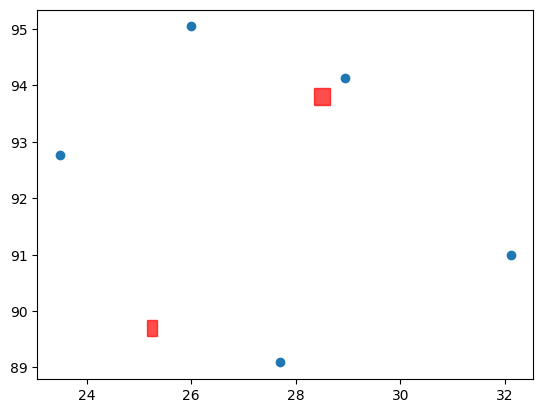

In [3108]:
# creating obstacles
obstacles = {
    0 : [[28.35, 93.65],[28.65, 93.95]],
    1 : [[25.15, 89.55],[25.35, 89.85]]
}

primary_plot(delivary_loc, obstacles)

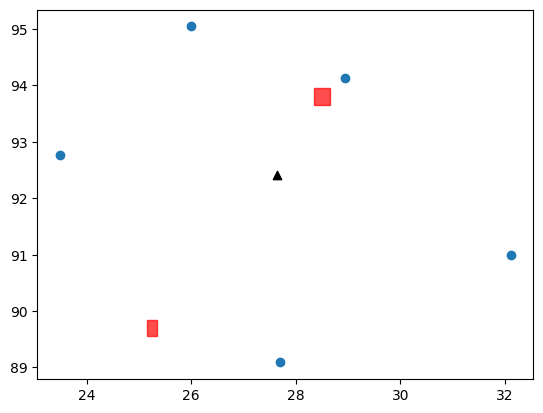

In [3109]:
# creating initial dp
initial_dp = calculate_dp(delivary_loc)

# visualize dp
plot_dp(initial_dp, delivary_loc, obstacles)

*calculate total distance from the initial dp*

In [3110]:
# calculate route
initial_route = create_route(delivary_loc,initial_dp)

for i in initial_route:
    print(i,"->",end=" ")
print("End")

[27.6459966913141, 92.40914216832343] -> [25.99424603293837, 95.045943467191] -> [27.6459966913141, 92.40914216832343] -> [27.688476751778296, 89.08885771115666] -> [27.6459966913141, 92.40914216832343] -> [28.94348059986981, 94.13828495424936] -> [27.6459966913141, 92.40914216832343] -> [23.49031162306026, 92.7756627019649] -> [27.6459966913141, 92.40914216832343] -> [32.11346844892377, 90.9969620070552] -> [27.6459966913141, 92.40914216832343] -> End


Initial Distance : 34.90192793898711


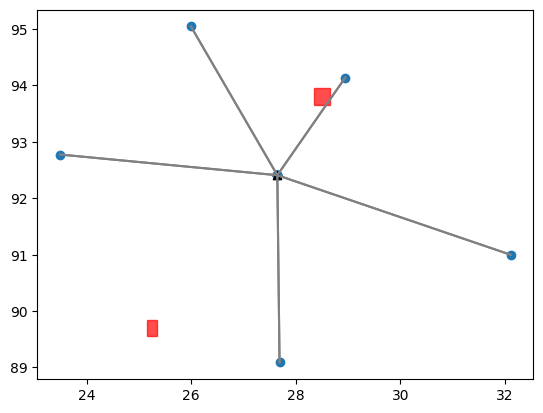

In [3111]:
# calculating distance
initial_dist = total_dist(initial_route)

print("Initial Distance :",initial_dist)

# Visualization
plot_initial_route(initial_dp, delivary_loc, obstacles, initial_route)

*check for obstacles in the path, if no obstacle then it is optimal dp and optimal path*

In [3112]:
THRESHOLD = initial_dist + (initial_dist*0.03)

if(detect_obstacle(initial_route, obstacles)):
    new_route = adv_route(initial_route, initial_dp, obstacles)
    new_dist = total_dist(new_route)
    if new_dist <= THRESHOLD:
        optimal_dp = initial_dp
        optimal_route = new_route
    # else relocate the dp
else:
    optimal_dp = initial_dp
    optimal_route = initial_route

print("Optimal dp :",optimal_dp)
print("Optimal route :",optimal_route)

Optimal dp : [27.6459966913141, 92.40914216832343]
Optimal route : [[27.6459966913141, 92.40914216832343], [25.99424603293837, 95.045943467191], [27.6459966913141, 92.40914216832343], [27.688476751778296, 89.08885771115666], [27.6459966913141, 92.40914216832343], [29.077089879516926, 93.65], [28.94348059986981, 94.13828495424936], [29.077089879516926, 93.65], [27.6459966913141, 92.40914216832343], [23.49031162306026, 92.7756627019649], [27.6459966913141, 92.40914216832343], [32.11346844892377, 90.9969620070552], [27.6459966913141, 92.40914216832343]]


## Result

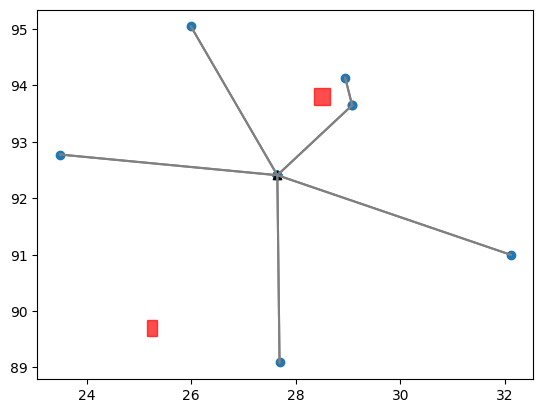

In [3113]:
plot_initial_route(optimal_dp,delivary_loc, obstacles, optimal_route)